In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
import geopandas as gpd
from matplotlib import transforms
import re
from shapely.geometry import Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
import gdal
import osr
from PIL import Image 
import cv2
from osgeo import gdal_array
from rasterio.plot import show
import random
import spectral
import h5py
import json
import math
from osgeo import gdal,ogr,osr
import affine
import matplotlib.gridspec as gridspec
from glob import glob
from datetime import datetime
import geopandas as gdp

# Open all three datasets

In [7]:
aviris = 'AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01'
aviris_mask= 'AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01_SWIRMask'

emas = 'eMASL1B_19910_10_20190806_1858_1910_V02_Georeferenced_v02'
emas_mask = 'eMASL1B_19910_10_20190806_1858_1910_V02_Georeferenced_v02_SWIRMask'

master = 'MASTERL1B_1981719_02_20190806_1851_1900_V01_georeferenced'
master_mask = 'MASTERL1B_1981719_02_20190806_1851_1900_V01_georeferenced_MIRMask_v02'

In [1]:

def stats(nums):
    print("n=",len(nums))
    print("Mean:", np.mean(nums))
    print("STDE:", np.std(nums))
    print("Median:", np.median(nums))
    print("Q1:", np.quantile(nums, .25))
    print("Q3:", np.quantile(nums, .75))
    print("Min:", np.min(nums))
    print("Max:", np.max(nums))
    print("Total Radiance", sum(nums))
    

In [2]:
# function that accepts img path, img fire mask path, and the band number in which radiance will be extracted from
# returns the distribution statistics from the radiance

def img_mask(img, mask_path , bandNum):
    with rio.open(mask_path) as src:
        mask = src.read(1)
    
    stack_fire = None
    with rio.open(img) as src:
        array = src.read()
        band = array[bandNum]
        extract = band[mask==1]
        if stack_fire is None:
            stack_fire = extract.copy()
        else:
            stack_fire = np.vstack((stack_fire, extract))
        return stats(stack_fire)
    

In [13]:
# function that accepts img path, img fire mask path, and the band number in which radiance will be extracted from
# returns radiance distribution of within the fire pixels

def img_mask(img, mask_path , bandNum):
    with rio.open(mask_path) as src:
        mask = src.read(1)
    
    stack_fire = None
    with rio.open(img) as src:
        array = src.read()
        band = array[bandNum]
        extract = band[mask==1]
        if stack_fire is None:
            stack_fire = extract.copy()
        else:
            stack_fire = np.vstack((stack_fire, extract))
        return stack_fire
    

In [14]:
# AVIRIS
aviris_rad = img_mask(aviris, aviris_mask, 213)


In [15]:
master_rad = img_mask(master, master_mask, 30)

In [16]:
emas_rad = img_mask(emas, emas_mask, 24)

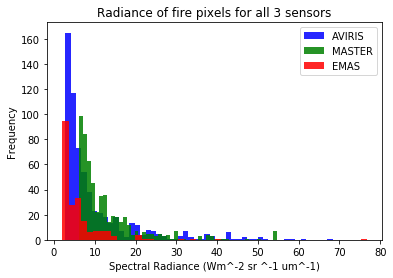

In [11]:
kwargs = dict(alpha=0.85, bins=50)

plt.hist(aviris_rad,**kwargs, color="b", label= 'AVIRIS')
plt.hist(master_rad,**kwargs, color= "g", label='MASTER')
plt.hist(emas_rad,**kwargs, color= "r", label='EMAS')
plt.gca().set(title='Radiance of fire pixels for all 3 sensors', ylabel='Frequency',
              xlabel= 'Spectral Radiance (Wm^-2 sr ^-1 um^-1)')

plt.legend();


In [17]:
print(stats(emas_rad))
print(stats(master_rad))
print(stats(aviris_rad))

n= 211
Mean: 6.2570143
STDE: 7.3063955
Median: 4.0499997
Q1: 2.6399998664855957
Q3: 6.579999923706055
Min: 2.08
Max: 76.689995
Total Radiance 1320.2299630641937
None
n= 558
Mean: 12.997814
STDE: 8.644712
Median: 9.745
Q1: 7.552499771118164
Q3: 14.90999984741211
Min: 6.18
Max: 54.66
Total Radiance 7252.779857635498
None
n= 645
Mean: 10.149871
STDE: 10.153446
Median: 6.041667
Q1: 4.058333396911621
Q3: 11.483333587646484
Min: 2.7916667
Max: 68.308334
Total Radiance 6546.667013168335
None


# Investigating fire--background pixels

# AVIRIS

In [64]:
# Change this to where ever your data files are located
data_dir = r"D:\Permanent Thesis Workspace\Final datasets of 3 sensors"
files = os.listdir(data_dir)

# header file of the image
data_hdr = r"D:\Permanent Thesis Workspace\Final datasets of 3 sensors\AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01.hdr"
data_hdr = glob(os.path.join(data_hdr))

def planck_um(lam, T):
    c1 = 1.191042*10**8
    c2 = 1.4387752*10**4
    return c1/(lam**5*(np.exp(c2/(lam*T))-1))

def inv_planck_um(lam, radiance):
    c1 = 1.191042*10**8
    c2 = 1.4387752*10**4
    return c2/(lam*np.log(c1/(lam**5*radiance)+1))

# Test functions
print(planck_um(11, 290), 'W/m2*sr*um should be ', 8.222077035769829,'W/m2*sr*um')
print(inv_planck_um(11, 1000), 'K should be ', 2362.5656807352184,'K')

8.222072203488061 W/m2*sr*um should be  8.222077035769829 W/m2*sr*um
2362.5793738804778 K should be  2362.5656807352184 K


In [65]:
# Extracting start and end times from defined image path
# When intputting file path,
#-----date, start-time, end-time, start date-time, end-time, and others are pulled from files that have '2019' in the name
def extract_start_end_datetime(file):
    date_index = file.find('2019')
    date = file[date_index:date_index+4]+"-"+file[date_index+4:date_index+6]+"-"+file[date_index+6:date_index+8]
    start_time = file[date_index+9: date_index+11]+":"+file[date_index+11:date_index+13]
    end_time = file[date_index+14: date_index+16]+":"+file[date_index+16:date_index+18]
    start_datetime = np.datetime64(date+"T"+start_time)
    end_datetime = np.datetime64(date+"T"+end_time)
    day_time = float(file[date_index+9: date_index+11])-7+float(file[date_index+11:date_index+13])/60
    return (start_datetime, end_datetime, day_time)

In [66]:
# The georeferenced images are the band_filenames list that is first down below

band_filenames = []
fdi_filenames = []
start_datetimes = []
day_times = []
end_datetimes = []
durations = []
flight_tracks = []

for file in files:
    if(file.endswith('sc01')):
        #print('bands',file)
        print('RadianceMask',file+"_SWIRMask") # 'fdi', file + "_fdi" is the original text
        #print(extract_start_end_datetime(file))
        (start_datetime, end_datetime, day_time) = extract_start_end_datetime(file)
        start_datetimes.append(start_datetime)
        end_datetimes.append(end_datetime)
        durations.append(end_datetime-start_datetime)
        band_filenames.append(file)
        fdi_filenames.append(file+"_SWIRMask")
        date_index = file.find('2019')
        flight_track = file[date_index-9:date_index-1]
        flight_tracks.append(flight_track)
        day_times.append(day_time)

print(start_datetimes)
        
df = pd.DataFrame({'flight_track':flight_tracks,'start_time':start_datetimes,'day_time':day_times, 'end_time':end_datetimes,
                   'duration':durations,'band_file':band_filenames, 'fdi_file':fdi_filenames})
df = df.sort_values('start_time')
df = df.reset_index(drop=True)

df['start_time']=df['start_time'].dt.tz_localize(tz='UTC')
df['start_time']=df['start_time'].dt.tz_convert(tz='US/Pacific')
df['end_time']=df['end_time'].dt.tz_localize(tz='UTC')
df['end_time']=df['end_time'].dt.tz_convert(tz='US/Pacific')


print(df)
print(df.dtypes)

RadianceMask AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01_SWIRMask
[numpy.datetime64('2019-08-06T18:41')]
  flight_track                start_time   day_time                  end_time  \
0     19910_06 2019-08-06 11:41:00-07:00  11.683333 2019-08-06 12:00:00-07:00   

  duration                                          band_file  \
0 00:19:00  AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01   

                                            fdi_file  
0  AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_s...  
flight_track                        object
start_time      datetime64[ns, US/Pacific]
day_time                           float64
end_time        datetime64[ns, US/Pacific]
duration                   timedelta64[ns]
band_file                           object
fdi_file                            object
dtype: object


In [67]:
def get_nonfire_neighbors(row, col, fdi):  #Takes in row, col, and fdi image
    nonfire_neighbors = []       
    (num_row, num_col) = fdi.shape         # Tuple is created consisting of # rows/columns based off of fdi image shape
 
    bound = 1                             # FDI image value 1? (1 Meaning fire)
    while(bound < 4 and len(nonfire_neighbors) < 4):  # The 'bound < 3' part means that it will --- 
                                                       # ---not look more than 3 pixels away from the current fire pixel,
            
        for i in range(row-bound, row+bound):   # for i in the range of the row bounds
            for j in range(col-bound, col+bound):  # for j in the range of columns
                if(fdi[i,j] == 0):                   # if both values of col/rows is equal to zero
                    nonfire_neighbors.append((i,j))     # append it to nonfire_neighbors empty list
        bound += 1
    return nonfire_neighbors

In [68]:
# header file information for the purposes of reading wavelength information
# Creation of a geodataframe filled with variables no limited to: xy coord, FRP data, and 
# ---background spectral radiance information, as we

fire_detect_data = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry",
                                             "dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon",
                                             "atmo_transmit","LfMIR","Lbkg"])

fire_detect_data.crs = "EPSG:32611"
#row_df = pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
#score_df = pd.concat([score_df, row_df], ignore_index=True)
fire_times = []
fire_frps = []
fire_datasets = []
fire_rows = []
fire_cols = []
fire_LfMIR = []
fire_Lbackground = []
fire_detection_times = []
fire_detection_number = []
fire_total_FRP = []

num_fire_no_background = 0
num_fire_pixels = 0
for index, row in df.iterrows():
    
    fire_time = row['start_time']
    fire_end_time = row["end_time"]
    band_file = row['band_file']
    fdi_file = row['fdi_file']
        
    # print(band_file)
    fp = data_dir+"/"+band_file
    #print(fp)
    raster = rio.open(fp)
    #print(raster)
    if (not raster.count == 224):
        continue
    
    for hdr in data_hdr:
        with open(hdr, "r") as src:
            #print(src)
            all_data = [line.strip() for line in src.readlines()]
            bands = all_data[243:]
            wls = []
            #print(all_data)
            for vals in bands:
                vals = vals.replace("\n","")
                #print(vals)
                vals1 = vals[0:10]
                vals2= vals[13:23]
                vals3= vals[26:36]
                vals4 = vals[39:49]
                vals5 = vals[52:62]
                vals6 = vals[65:75]
                #print(vals1)
                #print(vals2)
                #print(vals3)
                #print(vals4)
                #print(vals5)
                #print(vals6)
                wls.append(vals1)
                wls.append(vals2)
                wls.append(vals3)
                wls.append(vals4)
                wls.append(vals5)
                wls.append(vals6)
                #print(len(wls))
            new_wls = wls[0:224]
            wls= []
            for values in new_wls:
                wls.append(float(values))
    print("Number of bands:",len(wls))
    print(wls)
    wls = sorted(wls)
    
    band_data_array = raster.read()
    #print(len(band_data_array))

    #print(wls)
    fp_fdi = data_dir+"/"+fdi_file
    print(fp_fdi)
    raster_fdi = rio.open(fp_fdi)
    fdi_data_array = raster_fdi.read()[0]
    (row,col)=np.nonzero(fdi_data_array)

    fire_pixels = {}
    num_fire_pixels += len(row)
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_pixels[(row_ind, col_ind)] = get_nonfire_neighbors(row_ind, col_ind, fdi_data_array)

    
    
    MIR_ind = wls.index(2386.10498)
    #TIR_ind = wls.index(10.71)
    #rint(MIR_ind)
    #rint(TIR_ind)
    a = 5.14498521e-09 # T**4 fit coefficient
    b = 3.9600042e-12 # T**5 fit coefficient
    epsilon = 0.8   # Assume a value for emissivity for T**5 FRP
    sigma = 5.67*10**(-8)
    A = 16.4*16.4 # Pixel area is 19x19  meters
    atmo_transmit = 0.99788 # Atmospheric transmittance
    C = 3*10**8
    FRPs = []
    
    fire_detection_times.append(fire_time)
    fire_detection_number.append(len(row))
    total_FRP = 0
    
    frp_data_array = np.zeros_like(fdi_data_array, dtype=float)
    
    #"dataset","row","col","FRP","FRP_T5","epsilon","LfMIR","Lbkg"
    fire_detect_start_times = []
    fire_detect_end_times = []
    fire_detect_xcoords = []
    fire_detect_ycoords = []
    fire_detect_datasets = []
    fire_detect_rows = []
    fire_detect_cols = []
    fire_detect_FRPs = []
    fire_detect_FRP_T5s = []
    fire_detect_epsilons = []
    fire_detect_atmo_transmits = []
    fire_detect_LfMIRs_AVIRIS = []
    fire_detect_Lbkgs_AVIRIS = []
    fire_detect_FRP_ratios = []
    fire_detect_points = []
    
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_neighbors = fire_pixels[(row_ind, col_ind)]
        #rint(fire_neighbors) # says the specific column/row that contains a fire pixel
        #rint(len(fire_neighbors))
        num_fire_neighbors = len(fire_neighbors)
        if(num_fire_neighbors==0):
            num_fire_no_background+=1
            continue
   #print(row_ind, col_ind)
        fire_detect_start_times.append(fire_time)
        fire_detect_end_times.append(fire_end_time)
        fire_detect_datasets.append(band_file)
        
        fire_detect_rows.append(row_ind)
        fire_detect_cols.append(col_ind)
        (x_coord, y_coord) = rio.transform.xy(raster.transform, row_ind, col_ind, offset="ul")
        
        fire_detect_points.append(Point(x_coord, y_coord))
        fire_detect_xcoords.append(x_coord)
        fire_detect_ycoords.append(y_coord)
        fire_detect_epsilons.append(epsilon)
        fire_detect_atmo_transmits.append(atmo_transmit)
        
        L_background = 0
        for (row_n, col_n) in fire_neighbors:
            L_background += band_data_array[MIR_ind,row_n,col_n]
        L_background = L_background / num_fire_neighbors
        
        #print(band_data_array)
        LfMIR = (band_data_array[MIR_ind, row_ind, col_ind] - L_background)/atmo_transmit
        #rint(LfMIR)
        #print("Using the following parameters for FRP calculation: ","\nPixel Area: ",A, "\nSigma: ", 
           #  sigma, "\nLfMIR: ", LfMIR, "T**4 (a): ",a)
        
        FRP = A*sigma*LfMIR/a
        FRP_T5 =A*sigma*epsilon**(1./5)*(LfMIR**(4./5))/(b**(4./5))
        FRPs.append(FRP)
        #print(FRPs)
        
        fire_detect_Lbkgs_AVIRIS.append(L_background)
        fire_detect_LfMIRs_AVIRIS.append(LfMIR)
        #print(FRP)
        fire_detect_FRPs.append(FRP)
        fire_detect_FRP_T5s.append(FRP_T5)
        fire_detect_FRP_ratios.append(FRP_T5/FRP)
        
        fire_times.append(fire_time)
        fire_frps.append(FRP)
        fire_datasets.append(band_file)
        fire_rows.append(row_ind)
        fire_cols.append(col_ind)
        fire_LfMIR.append(LfMIR)
        fire_Lbackground.append(L_background)
        total_FRP += FRP
        frp_data_array[row_ind, col_ind] = FRP
   
    
    
    fire_total_FRP.append(total_FRP)
    print(len(fire_detect_start_times), len(fire_detect_FRPs))
    fire_detect_flighttrack = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry","dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon","atmo_transmit","LfMIR","Lbkg"])
    fire_detect_flighttrack["start_time"] = fire_detect_start_times
    fire_detect_flighttrack["end_time"] = fire_detect_end_times
    fire_detect_flighttrack["x_coord"] = fire_detect_xcoords
    fire_detect_flighttrack["y_coord"] = fire_detect_ycoords
    fire_detect_flighttrack["dataset"] = fire_detect_datasets
    fire_detect_flighttrack["row"] = fire_detect_rows
    fire_detect_flighttrack["col"] = fire_detect_cols
    fire_detect_flighttrack["FRP"] = fire_detect_FRPs
    fire_detect_flighttrack["FRP_T5"] = fire_detect_FRP_T5s
    fire_detect_flighttrack["FRP_ratio"] = fire_detect_FRP_ratios
    fire_detect_flighttrack["epsilon"] = fire_detect_epsilons
    fire_detect_flighttrack["atmo_transmit"] = fire_detect_atmo_transmits
    fire_detect_flighttrack["LfMIR"] = fire_detect_LfMIRs_AVIRIS
    fire_detect_flighttrack["Lbkg"] = fire_detect_Lbkgs_AVIRIS
    
    s = gpd.GeoSeries(fire_detect_points)
    s.crs = "EPSG:32611"
    fire_detect_flighttrack['geometry'] = s
    
    # "FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"
    #,columns=["start_time","end_time","lat","lon","dataset","row","col","FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"]
    #pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
    fire_detect_data = gpd.GeoDataFrame(pd.concat([fire_detect_data, fire_detect_flighttrack], ignore_index=True))
    

    
# ----------Exploratory statistics for fire radiance
print("Stats for fire pixels: ")
print("\tMin radiance of fire", np.min(fire_detect_LfMIRs_AVIRIS), "\n\tMax",np.max(fire_detect_LfMIRs_AVIRIS))
print("\tMean radiance of fire", np.mean(fire_detect_LfMIRs_AVIRIS))
print("\tStandard Deviation",np.std(fire_detect_LfMIRs_AVIRIS))
# ----------Exploratory statistics for fire background radiance
print("Stats for fire-background pixels: ")
print("\tMin radiance of fire background", np.min(fire_detect_Lbkgs_AVIRIS), "\n\tMax",np.max(fire_detect_Lbkgs_AVIRIS))
print("\tMean radiance of fire background", np.mean(fire_detect_Lbkgs_AVIRIS))
print("\tStandard Deviation of fire background",np.std(fire_detect_Lbkgs_AVIRIS))


fire_detect_data.crs = "EPSG:32611"
print("\tfire pixels =",num_fire_pixels)
print("\tNon Fire pixels:", len(fire_detect_Lbkgs_AVIRIS))
print("\tfire pixels with no non-fire neighbors=",num_fire_no_background)     

Number of bands: 224
[365.92981, 375.593994, 385.262512, 394.935486, 404.612915, 414.294586, 423.980804, 433.671295, 443.366211, 453.065491, 462.769196, 472.477295, 482.189789, 491.906586, 501.627899, 511.353485, 521.083618, 530.817993, 540.556824, 550.299988, 560.047729, 569.799622, 579.55603, 589.316772, 599.081909, 608.851501, 618.625427, 628.403687, 638.186523, 647.973572, 657.765076, 667.560974, 654.792297, 664.599426, 674.401184, 684.197876, 693.98938, 703.775574, 713.55658, 723.33252, 733.103088, 742.86853, 752.628723, 762.383728, 772.133484, 781.878113, 791.617371, 801.351624, 811.080505, 820.804321, 830.522827, 840.236084, 849.944214, 859.647095, 869.344788, 879.03717, 888.724487, 898.406616, 908.083374, 917.755127, 927.421387, 937.082703, 946.738708, 956.389526, 966.035095, 975.675476, 985.310608, 994.940613, 4.565002, 14.184998, 23.799011, 33.407959, 1043.01196, 1052.61096, 1062.20397, 1071.79296, 1081.37597, 1090.95397, 1100.526, 1110.09399, 1119.656, 1129.21301, 1138.76501

# eMAS

In [69]:
def get_nonfire_neighbors(row, col, fdi):  #Takes in row, col, and fdi image
    nonfire_neighbors = []       
    (num_row, num_col) = fdi.shape         # Tuple is created consisting of # rows/columns based off of fdi image shape
 
    bound = 1                             # FDI image value 1? (1 Meaning fire)
    while(bound < 2 and len(nonfire_neighbors) < 2):  # The 'bound < 3' part means that it will --- 
                                                       # ---not look more than 3 pixels away from the current fire pixel,
            
        for i in range(row-bound, row+bound):   # for i in the range of the row bounds
            for j in range(col-bound, col+bound):  # for j in the range of columns
                if(fdi[i,j] == 0):                   # if both values of col/rows is equal to zero
                    nonfire_neighbors.append((i,j))     # append it to nonfire_neighbors empty list
        bound += 1
    return nonfire_neighbors

In [70]:
# The georeferenced images are the band_filenames list that is first down below

band_filenames = []
fdi_filenames = []
start_datetimes = []
day_times = []
end_datetimes = []
durations = []
flight_tracks = []

for file in files:
    if(file.endswith('_v02')):
        #print('bands',file)
        print('fdi',file+"_SWIRMask")
        #print(extract_start_end_datetime(file))
        (start_datetime, end_datetime, day_time) = extract_start_end_datetime(file)
        start_datetimes.append(start_datetime)
        end_datetimes.append(end_datetime)
        durations.append(end_datetime-start_datetime)
        band_filenames.append(file)
        fdi_filenames.append(file+"_SWIRMask")
        date_index = file.find('2019')
        flight_track = file[date_index-9:date_index-1]
        flight_tracks.append(flight_track)
        day_times.append(day_time)
        
df = pd.DataFrame({'flight_track':flight_tracks,'start_time':start_datetimes,'day_time':day_times, 'end_time':end_datetimes,
                   'duration':durations,'band_file':band_filenames, 'fdi_file':fdi_filenames})
df = df.sort_values('start_time')
df = df.reset_index(drop=True)

df['start_time']=df['start_time'].dt.tz_localize(tz='UTC')
df['start_time']=df['start_time'].dt.tz_convert(tz='US/Pacific')
df['end_time']=df['end_time'].dt.tz_localize(tz='UTC')
df['end_time']=df['end_time'].dt.tz_convert(tz='US/Pacific')


print(df)
print(df.dtypes)

fdi eMASL1B_19910_10_20190806_1858_1910_V02_Georeferenced_v02_SWIRMask
fdi MASTERL1B_1981719_02_20190806_1851_1900_V01_georeferenced_MIRMask_v02_SWIRMask
  flight_track                start_time   day_time                  end_time  \
0     81719_02 2019-08-06 11:51:00-07:00  11.850000 2019-08-06 12:00:00-07:00   
1     19910_10 2019-08-06 11:58:00-07:00  11.966667 2019-08-06 12:10:00-07:00   

  duration                                          band_file  \
0 00:09:00  MASTERL1B_1981719_02_20190806_1851_1900_V01_ge...   
1 00:12:00  eMASL1B_19910_10_20190806_1858_1910_V02_Georef...   

                                            fdi_file  
0  MASTERL1B_1981719_02_20190806_1851_1900_V01_ge...  
1  eMASL1B_19910_10_20190806_1858_1910_V02_Georef...  
flight_track                        object
start_time      datetime64[ns, US/Pacific]
day_time                           float64
end_time        datetime64[ns, US/Pacific]
duration                   timedelta64[ns]
band_file                 

In [71]:
fire_detect_data = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry","dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon","atmo_transmit","LfMIR","Lbkg"])
fire_detect_data.crs = "EPSG:32611"
#row_df = pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
#score_df = pd.concat([score_df, row_df], ignore_index=True)
fire_times = []
fire_frps = []
fire_datasets = []
fire_rows = []
fire_cols = []
fire_LfMIR = []
fire_Lbackground = []

fire_detection_times = []
fire_detection_number = []
fire_total_FRP = []

num_fire_no_background = 0
num_fire_pixels = 0
for index, row in df.iterrows():
    fire_time = row['start_time']
    fire_end_time = row["end_time"]
    band_file = row['band_file']
    fdi_file = row['fdi_file']
    
    print(band_file)
    fp = data_dir+"/"+band_file
    raster = rio.open(fp)
    if(not raster.count == 37):
        continue
    transform = raster.transform
    
    band_data = raster.tags()
    wls = []
    for band in band_data.keys():
        band = band_data[band]
        #print(band)
        band = band.split(")")[4]
        band = band.split("(")[1]
        print(band)
            
        wls.append(float(band))
    wls = sorted(wls)
  #  print(wls)
          
    band_data_array = raster.read()

    fp_fdi = data_dir+"/"+fdi_file
    raster_fdi = rio.open(fp_fdi)
    fdi_data_array = raster_fdi.read()[0]
    (row,col)=np.nonzero(fdi_data_array)

    fire_pixels = {}
    num_fire_pixels += len(row)
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_pixels[(row_ind, col_ind)] = get_nonfire_neighbors(row_ind, col_ind, fdi_data_array)

    MIR_ind = wls.index(2.382)
    #print(MIR_ind)
    TIR_ind = wls.index(10.995)
    a = 5.14782174e-09 # T**4 fit coefficient
    b = 3.96245043e-12  # T**5 fit coefficient
    epsilon = 0.8   # Assume a value for emissivity for T**5 FRP
    sigma = 5.67*10**(-8)
    A = 50*50 # Pixel area is 50x50  meters (18 x 18 due to stacking of realign images)
    atmo_transmit = 0.99735 # Atmospheric transmittance
    FRPs=[]
    
    fire_detection_times.append(fire_time)
    fire_detection_number.append(len(row))
    total_FRP = 0
    
    frp_data_array = np.zeros_like(fdi_data_array, dtype=float)
    
    #"dataset","row","col","FRP","FRP_T5","epsilon","LfMIR","Lbkg"
    fire_detect_start_times = []
    fire_detect_end_times = []
    fire_detect_xcoords = []
    fire_detect_ycoords = []
    fire_detect_datasets = []
    fire_detect_rows = []
    fire_detect_cols = []
    fire_detect_FRPs = []
    fire_detect_FRP_T5s = []
    fire_detect_epsilons = []
    fire_detect_atmo_transmits = []
    fire_detect_LfMIRs_emas = []
    fire_detect_Lbkgs_emas = []
    fire_detect_FRP_ratios = []
    fire_detect_points = []
    
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_neighbors = fire_pixels[(row_ind, col_ind)]
        num_fire_neighbors = len(fire_neighbors)
        if(num_fire_neighbors==0):
            num_fire_no_background+=1
            continue
        
            
        fire_detect_start_times.append(fire_time)
        fire_detect_end_times.append(fire_end_time)
        fire_detect_datasets.append(band_file)
        
        fire_detect_rows.append(row_ind)
        fire_detect_cols.append(col_ind)
        (x_coord, y_coord) = rio.transform.xy(raster.transform, row_ind, col_ind, offset="ul")
        
        fire_detect_points.append(Point(x_coord, y_coord))
        fire_detect_xcoords.append(x_coord)
        fire_detect_ycoords.append(y_coord)
        fire_detect_epsilons.append(epsilon)
        fire_detect_atmo_transmits.append(atmo_transmit)
        
        L_background = 0
        for (row_n, col_n) in fire_neighbors:
            L_background += band_data_array[MIR_ind,row_n,col_n]
        L_background = L_background / num_fire_neighbors
        LfMIR = (band_data_array[MIR_ind, row_ind, col_ind] - L_background) /atmo_transmit
        #print(LfMIR)
        # print("Using the following parameters for FRP calculation: ","\nPixel Area: ",A, "\nSigma: ", 
          # sigma, "\nLfMIR: ", LfMIR, "T**4 (a): ",a)
        
        FRP = A*sigma*LfMIR/a
        FRP_T5 = (A*sigma*epsilon**(1./5)*(LfMIR**(4./5))/(b**(4./5)))
        FRPs.append(FRP)
        #print(FRPs)
        
        fire_detect_Lbkgs_emas.append(L_background)
        fire_detect_LfMIRs_emas.append(LfMIR)
        #print(FRP_T5)
        fire_detect_FRPs.append(FRP)
        fire_detect_FRP_T5s.append(FRP_T5)
        fire_detect_FRP_ratios.append(FRP_T5/FRP)
        
        fire_times.append(fire_time)
        fire_frps.append(FRP)
        fire_datasets.append(band_file)
        fire_rows.append(row_ind)
        fire_cols.append(col_ind)
        fire_LfMIR.append(LfMIR)
        fire_Lbackground.append(L_background)
        total_FRP += FRP
        frp_data_array[row_ind, col_ind] = FRP
   
    
    
    fire_total_FRP.append(total_FRP)
    print(len(fire_detect_start_times), len(fire_detect_FRPs))
    fire_detect_flighttrack = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry","dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon","atmo_transmit","LfMIR","Lbkg"])
    fire_detect_flighttrack["start_time"] = fire_detect_start_times
    fire_detect_flighttrack["end_time"] = fire_detect_end_times
    fire_detect_flighttrack["x_coord"] = fire_detect_xcoords
    fire_detect_flighttrack["y_coord"] = fire_detect_ycoords
    fire_detect_flighttrack["dataset"] = fire_detect_datasets
    fire_detect_flighttrack["row"] = fire_detect_rows
    fire_detect_flighttrack["col"] = fire_detect_cols
    fire_detect_flighttrack["FRP"] = fire_detect_FRPs
    fire_detect_flighttrack["FRP_T5"] = fire_detect_FRP_T5s
    fire_detect_flighttrack["FRP_ratio"] = fire_detect_FRP_ratios
    fire_detect_flighttrack["epsilon"] = fire_detect_epsilons
    fire_detect_flighttrack["atmo_transmit"] = fire_detect_atmo_transmits
    fire_detect_flighttrack["LfMIR"] = fire_detect_LfMIRs_emas
    fire_detect_flighttrack["Lbkg"] = fire_detect_Lbkgs_emas
    
    s = gpd.GeoSeries(fire_detect_points)
    s.crs = "EPSG:32611"
    fire_detect_flighttrack['geometry'] = s
    
    # "FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"
    #,columns=["start_time","end_time","lat","lon","dataset","row","col","FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"]
    #pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
    fire_detect_data = gpd.GeoDataFrame(pd.concat([fire_detect_data, fire_detect_flighttrack], ignore_index=True))
    
# ----------Exploratory statistics for fire radiance
print("Stats for fire pixels: ")
print("Number of fire pixels", len(fire_detect_LfMIRs_emas))
print("\tMin radiance of fire", np.min(fire_detect_LfMIRs_emas), "\n\tMax",np.max(fire_detect_LfMIRs_emas))
print("\tMean radiance of fire", np.mean(fire_detect_LfMIRs_emas))
print("\tStandard Deviation",np.std(fire_detect_LfMIRs_emas))


# ----------Exploratory statistics for fire background radiance
print("Stats for fire-background pixels: ")
print("\tMin radiance of fire background", np.min(fire_detect_Lbkgs_emas), "\n\tMax",np.max(fire_detect_Lbkgs_emas))
print("\tMean radiance of fire background", np.mean(fire_detect_Lbkgs_emas))
print("\tStandard Deviation of fire background",np.std(fire_detect_Lbkgs_emas))


fire_detect_data.crs = "EPSG:32611"
print("\tfire pixels =",num_fire_pixels)
print("\tNon Fire pixels:", len(fire_detect_Lbkgs_emas))
print("\tfire pixels with no non-fire neighbors=",num_fire_no_background)   
  

MASTERL1B_1981719_02_20190806_1851_1900_V01_georeferenced_MIRMask_v02
eMASL1B_19910_10_20190806_1858_1910_V02_Georeferenced_v02
0.474000
1.614000
1.670000
1.724000
1.778000
1.830000
1.876000
1.932000
1.982000
2.034000
2.084000
0.552000
2.132000
2.182000
2.232000
2.282000
2.332000
2.382000
6.685000
7.255000
8.185000
8.515000
0.654000
9.695000
10.165000
10.995000
11.995000
12.565000
13.315000
13.605000
13.925000
0.706000
0.748000
0.830000
0.868000
0.910000
0.948000
171 171
Stats for fire pixels: 
Number of fire pixels 171
	Min radiance of fire 0.13702970478528748 
	Max 75.976332130304
	Mean radiance of fire 5.4053767170399105
	Standard Deviation 7.858688659990039
Stats for fire-background pixels: 
	Min radiance of fire background 0.0 
	Max 2.0033332904179892
	Mean radiance of fire background 0.9329824340448045
	Standard Deviation of fire background 0.6203255784001696
	fire pixels = 211
	Non Fire pixels: 171
	fire pixels with no non-fire neighbors= 40


# MASTER

In [72]:
def get_nonfire_neighbors(row, col, fdi):  #Takes in row, col, and fdi image
    nonfire_neighbors = []       
    (num_row, num_col) = fdi.shape         # Tuple is created consisting of # rows/columns based off of fdi image shape
 
    bound = 1                             # FDI image value 1? (1 Meaning fire)
    while(bound < 4 and len(nonfire_neighbors) < 4):  # The 'bound < 3' part means that it will --- 
                                                       # ---not look more than 3 pixels away from the current fire pixel,
            
        for i in range(row-bound, row+bound):   # for i in the range of the row bounds
            for j in range(col-bound, col+bound):  # for j in the range of columns
                if(fdi[i,j] == 0):                   # if both values of col/rows is equal to zero
                    nonfire_neighbors.append((i,j))     # append it to nonfire_neighbors empty list
        bound += 1
    return nonfire_neighbors

In [73]:
# The georeferenced images are the band_filenames list that is first down below

band_filenames = []
fdi_filenames = []
start_datetimes = []
day_times = []
end_datetimes = []
durations = []
flight_tracks = []

for file in files:
    #print(file)
    if(file.endswith('_georeferenced')):
        #print('bands',file)                # shortwave via radiance threshold
        #print('Radiance',file+"_MIRMask")  # 'fdi', file + "_fdi" is the original text
        #print(extract_start_end_datetime(file))
        (start_datetime, end_datetime, day_time) = extract_start_end_datetime(file)
        start_datetimes.append(start_datetime)
        end_datetimes.append(end_datetime)
        durations.append(end_datetime-start_datetime)
        band_filenames.append(file)
        fdi_filenames.append(file + "_MIRMask_v02")
        date_index = file.find('2019')
        flight_track = file[date_index-9:date_index-1]
        flight_tracks.append(flight_track)
        day_times.append(day_time)
    
print(start_datetimes)
    
df = pd.DataFrame({'flight_track':flight_tracks,'start_time':start_datetimes,'day_time':day_times, 'end_time':end_datetimes,
                   'duration':durations,'band_file':band_filenames, 'fdi_file':fdi_filenames})
df = df.sort_values('start_time')
df = df.reset_index(drop=True)
 
df['start_time']=df['start_time'].dt.tz_localize(tz='UTC')
df['start_time']=df['start_time'].dt.tz_convert(tz='US/Pacific')
df['end_time']=df['end_time'].dt.tz_localize(tz='UTC')
df['end_time']=df['end_time'].dt.tz_convert(tz='US/Pacific')


print(df)
print(df.dtypes)

[numpy.datetime64('2019-08-06T18:51')]
  flight_track                start_time  day_time                  end_time  \
0     81719_02 2019-08-06 11:51:00-07:00     11.85 2019-08-06 12:00:00-07:00   

  duration                                          band_file  \
0 00:09:00  MASTERL1B_1981719_02_20190806_1851_1900_V01_ge...   

                                            fdi_file  
0  MASTERL1B_1981719_02_20190806_1851_1900_V01_ge...  
flight_track                        object
start_time      datetime64[ns, US/Pacific]
day_time                           float64
end_time        datetime64[ns, US/Pacific]
duration                   timedelta64[ns]
band_file                           object
fdi_file                            object
dtype: object


In [74]:
def get_nonfire_neighbors(row, col, fdi):  #Takes in row, col, and fdi image
    nonfire_neighbors = []       
    (num_row, num_col) = fdi.shape  # Tuple is created consisting of # rows/columns based off of fdi image shape(demensions)
 
    bound = 1                            
    while(bound < 4 and len(nonfire_neighbors) < 4):  # The 'bound < 3' part means that it will --- 
                                                      # ---not look more than 3 pixels away from the current fire pixel,
        for i in range(row-bound, row+bound):   # for i in the range of the row bounds
            for j in range(col-bound, col+bound):  # for j in the range of columns
                if(fdi[i,j] == 0):                   # if both values of col/rows is equal to zero
                    nonfire_neighbors.append((i,j))     # append it to nonfire_neighbors empty list
        bound += 1
    return nonfire_neighbors


In [75]:
# Creation of a geodataframe filled with variables no limited to: xy coord, FRP data, and 
# ---background spectral radiance information, as we

fire_detect_data = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry",
                                             "dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon",
                                             "atmo_transmit","LfMIR","Lbkg"])

fire_detect_data.crs = "EPSG:32611"
#row_df = pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
#score_df = pd.concat([score_df, row_df], ignore_index=True)
fire_times = []
fire_frps = []
fire_datasets = []
fire_rows = []
fire_cols = []
fire_LfMIR = []
fire_Lbackground = []

fire_detection_times = []
fire_detection_number = []
fire_total_FRP = []

num_fire_no_background = 0
num_fire_pixels = 0
for index, row in df.iterrows():
    
    fire_time = row['start_time']
    fire_end_time = row["end_time"]
    band_file = row['band_file']
    fdi_file = row['fdi_file']
        
    #print(band_file)
    fp = data_dir+"/"+band_file
    #print(fp)
    raster = rio.open(fp)
    if(not raster.count == 49):
        continue
    #print(raster)
    transform = raster.transform
    band_data = raster.tags()
    #print(band_data)
    wls = []
    for band in band_data.keys():
        band = band_data[band]
        band = band.split(")")[2]
        band = band.split("(")[1]
        #print(band)
        wls.append(float(band))
    wls= sorted(wls)
   #print(wls)
    
    band_data_array = raster.read()
    #print(len(band_data_array))

    #print(wls)
    fp_fdi = data_dir+"/"+fdi_file
    print(fp_fdi)
    raster_fdi = rio.open(fp_fdi)
    fdi_data_array = raster_fdi.read()[0]
    (row,col)=np.nonzero(fdi_data_array)

    fire_pixels = {}
    num_fire_pixels += len(row)
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_pixels[(row_ind, col_ind)] = get_nonfire_neighbors(row_ind, col_ind, fdi_data_array)

    
    
    MIR_ind = wls.index(4.06)
    TIR_ind = wls.index(10.71)
    #rint(MIR_ind)
    #rint(TIR_ind)
    a = 2.632953e-09 # T**4 fit coefficient
    b = 1.98805018e-12 # T**5 fit coefficient
    epsilon = 0.8   # Assume a value for emissivity for T**5 FRP
    sigma = 5.67*10**(-8) #stephan boltzmans
    A = 18.0 * 18.0 # Pixel area is the sptial resolution in  meters
    atmo_transmit = 0.93695 # Atmospheric transmittance
    FRPs = []
    
    fire_detection_times.append(fire_time)
    fire_detection_number.append(len(row))
    total_FRP = 0
    
    frp_data_array = np.zeros_like(fdi_data_array, dtype=float)
    
    #"dataset","row","col","FRP","FRP_T5","epsilon","LfMIR","Lbkg"
    fire_detect_start_times = []
    fire_detect_end_times = []
    fire_detect_xcoords = []
    fire_detect_ycoords = []
    fire_detect_datasets = []
    fire_detect_rows = []
    fire_detect_cols = []
    fire_detect_FRPs = []
    fire_detect_FRP_T5s = []
    fire_detect_epsilons = []
    fire_detect_atmo_transmits = []
    fire_detect_LfMIRs_master = []
    fire_detect_Lbkgs_master = []
    fire_detect_FRP_ratios = []
    fire_detect_points = []
    
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_neighbors = fire_pixels[(row_ind, col_ind)]
        #rint(fire_neighbors) # says the specific column/row that contains a fire pixel
        #rint(len(fire_neighbors))
        num_fire_neighbors = len(fire_neighbors)
        if(num_fire_neighbors==0):
            num_fire_no_background+=1
            continue
   #print(row_ind, col_ind)
        fire_detect_start_times.append(fire_time)
        fire_detect_end_times.append(fire_end_time)
        fire_detect_datasets.append(band_file)
        
        fire_detect_rows.append(row_ind)
        fire_detect_cols.append(col_ind)
        (x_coord, y_coord) = rio.transform.xy(raster.transform, row_ind, col_ind, offset="ul")
        
        fire_detect_points.append(Point(x_coord, y_coord))
        fire_detect_xcoords.append(x_coord)
        fire_detect_ycoords.append(y_coord)
        fire_detect_epsilons.append(epsilon)
        fire_detect_atmo_transmits.append(atmo_transmit)
        
        L_background = 0
        for (row_n, col_n) in fire_neighbors:
            L_background += band_data_array[MIR_ind,row_n,col_n]
        L_background = L_background / num_fire_neighbors

        LfMIR = (band_data_array[MIR_ind, row_ind, col_ind] - L_background) / atmo_transmit
        FRP = A*sigma*LfMIR/a
        FRP_T5 = A*sigma*epsilon**(1./5)*(LfMIR**(4./5))/(b**(4./5))
        FRPs.append(FRP)
        
        fire_detect_Lbkgs_master.append(L_background)
        fire_detect_LfMIRs_master.append(LfMIR)
        #print(FRP)
        fire_detect_FRPs.append(FRP)
        fire_detect_FRP_T5s.append(FRP_T5)
        fire_detect_FRP_ratios.append(FRP_T5/FRP)
        
        fire_times.append(fire_time)
        fire_frps.append(FRP)
        fire_datasets.append(band_file)
        fire_rows.append(row_ind)
        fire_cols.append(col_ind)
        fire_LfMIR.append(LfMIR)
        fire_Lbackground.append(L_background)
        total_FRP += FRP
        frp_data_array[row_ind, col_ind] = FRP
        
        
        fire_total_FRP.append(total_FRP)

        #print(len(fire_detect_start_times), len(fire_detect_FRPs))
    fire_detect_flighttrack = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry","dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon","atmo_transmit","LfMIR","Lbkg"])
    fire_detect_flighttrack["start_time"] = fire_detect_start_times
    fire_detect_flighttrack["end_time"] = fire_detect_end_times
    fire_detect_flighttrack["x_coord"] = fire_detect_xcoords
    fire_detect_flighttrack["y_coord"] = fire_detect_ycoords
    fire_detect_flighttrack["dataset"] = fire_detect_datasets
    fire_detect_flighttrack["row"] = fire_detect_rows
    fire_detect_flighttrack["col"] = fire_detect_cols
    fire_detect_flighttrack["FRP"] = fire_detect_FRPs
    fire_detect_flighttrack["FRP_T5"] = fire_detect_FRP_T5s
    fire_detect_flighttrack["FRP_ratio"] = fire_detect_FRP_ratios
    fire_detect_flighttrack["epsilon"] = fire_detect_epsilons
    fire_detect_flighttrack["atmo_transmit"] = fire_detect_atmo_transmits
    fire_detect_flighttrack["LfMIR"] = fire_detect_LfMIRs_master
    fire_detect_flighttrack["Lbkg"] = fire_detect_Lbkgs_master
    
    s = gpd.GeoSeries(fire_detect_points)
    s.crs = "EPSG:32611"
    fire_detect_flighttrack['geometry'] = s
    
    # "FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"
    #,columns=["start_time","end_time","lat","lon","dataset","row","col","FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"]
    #pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
    fire_detect_data = gpd.GeoDataFrame(pd.concat([fire_detect_data, fire_detect_flighttrack], ignore_index=True))

# ----------Exploratory statistics for fire radiance
print("Stats for fire pixels: ")
print("\tMin radiance of fire", np.min(fire_detect_LfMIRs_master), "\n\tMax",np.max(fire_detect_LfMIRs_master))
print("\tMean radiance of fire", np.mean(fire_detect_LfMIRs_master))
print("\tStandard Deviation",np.std(fire_detect_LfMIRs_master))


# ----------Exploratory statistics for fire background radiance
print("Stats for fire-background pixels: ")
print("\tMin radiance of fire background", np.min(fire_detect_Lbkgs_master), "\n\tMax",np.max(fire_detect_Lbkgs_master))
print("\tMean radiance of fire background", np.mean(fire_detect_Lbkgs_master))
print("\tStandard Deviation of fire background",np.std(fire_detect_Lbkgs_master))


fire_detect_data.crs = "EPSG:32611"
print("\tfire pixels =",num_fire_pixels)
print("\tNon Fire pixels:", len(fire_detect_Lbkgs_master))
print("\tfire pixels with no non-fire neighbors=",num_fire_no_background)   
  

D:\Permanent Thesis Workspace\Final datasets of 3 sensors/MASTERL1B_1981719_02_20190806_1851_1900_V01_georeferenced_MIRMask_v02
Stats for fire pixels: 
	Min radiance of fire 1.624419620176737 
	Max 58.33822492919805
	Mean radiance of fire 11.188356238861207
	Standard Deviation 9.616823497071747
Stats for fire-background pixels: 
	Min radiance of fire background 0.0 
	Max 5.1912499368190765
	Mean radiance of fire background 2.514882986937161
	Standard Deviation of fire background 1.0879906424422174
	fire pixels = 558
	Non Fire pixels: 558
	fire pixels with no non-fire neighbors= 0


# Comparison of background

C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


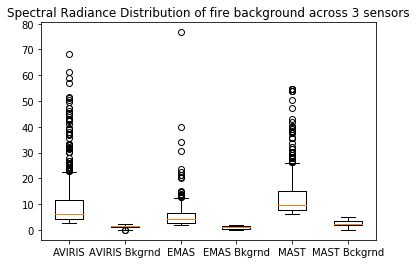

<Figure size 432x288 with 0 Axes>

In [76]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([aviris_rad, fire_detect_Lbkgs_AVIRIS, emas_rad ,fire_detect_Lbkgs_emas, master_rad,fire_detect_Lbkgs_master],
            labels= ["AVIRIS","AVIRIS Bkgrnd", "EMAS", "EMAS Bkgrnd", "MAST", "MAST Bckgrnd"])
ax.set_title('Spectral Radiance Distribution of fire background across 3 sensors')


plt.show()
plt.savefig("Radiance distribution fire_bckgrnd")

C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


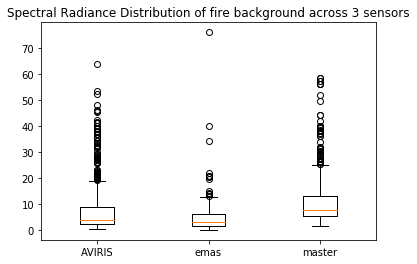

<Figure size 432x288 with 0 Axes>

In [77]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([fire_detect_LfMIRs_AVIRIS, fire_detect_LfMIRs_emas, fire_detect_LfMIRs_master],
            labels= ["AVIRIS","emas", "master"])
ax.set_title('Spectral Radiance Distribution of fire background across 3 sensors')


plt.show()
plt.savefig("Radiance distribution fire_bckgrnd")